### Y2018M02D16_RH_Number_Streams_Per_Basin_V01

* Purpose of script: determine the number of streams per GDBD basin
* Author: Rutger Hofste
* Kernel used: python35
* Date created: 20180216

In [1]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
sys.version

Y2018M02D16 UTC 15:37


'3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 13:26:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [2]:
SCRIPT_NAME = "Y2018M02D16_RH_Number_Streams_Per_Basin_V01"

EC2_INPUT_PATH  = ("/volumes/data/{}/input/").format(SCRIPT_NAME)
EC2_OUTPUT_PATH = ("/volumes/data/{}/output/").format(SCRIPT_NAME)

S3_INPUT_PATH = "s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/"
S3_OUTPUT_PATH = "s3://wri-projects/Aqueduct30/processData/{}/output".format(SCRIPT_NAME)


INPUT_VERSION = 6
OUTPUT_VERSION = 1

In [3]:
!rm -r {EC2_INPUT_PATH}
!rm -r {EC2_OUTPUT_PATH}

!mkdir -p {EC2_INPUT_PATH}
!mkdir -p {EC2_OUTPUT_PATH}

In [4]:
!aws s3 cp {S3_INPUT_PATH} {EC2_INPUT_PATH} --recursive

download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_basins_EPSG4326_V06.cpg to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_basins_EPSG4326_V06.cpg
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_streams_EPSG4326_V06.cpg to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_streams_EPSG4326_V06.cpg
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_basins_EPSG4326_V06.prj to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_basins_EPSG4326_V06.prj
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_basins_EPSG4326_V06.shx to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_basins_EPSG4326_V06.shx
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_streams_EPSG4326_V06.dbf to ../../../../d

In [5]:
import geopandas as gpd
import pandas as pd
import eeconvert
import folium


%matplotlib inline

In [6]:
file_name = "{}GDBD_streams_EPSG4326_V{:02.0f}.shp".format(EC2_INPUT_PATH,INPUT_VERSION)

In [7]:
print(file_name)

/volumes/data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_streams_EPSG4326_V06.shp


In [8]:
gdf = gpd.GeoDataFrame.from_file(file_name)

In [9]:
gdf2 = gdf.copy()

In [10]:
gdf2['GDBD_ID'] = gdf2['GDBD_ID'].astype('int64')

In [11]:
gdf2.dtypes

OBJECTID        int64
GDBD_ID         int64
Ave_Str_Sl    float64
Shape_Leng    float64
geometry       object
dtype: object

In [12]:
def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out
    

Strategy (https://gis.stackexchange.com/questions/132723/unsplit-dissolve-multiple-touching-lines-in-stream-network-using-arcgis-desktop)

1. Explode multilines into single lines 
1. Tiny buffer around single lines
1. Take Union
1. Spatial join single line geodataframe and dissolved ID's 
1. Aggregate using polyline ID from previous step



In [13]:
gdf_out = explode(gdf2)

In [14]:
gdf_test = gdf_out[1:1000]

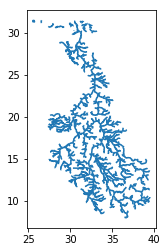

In [15]:
gdf_test.plot()

In [16]:
gdf_test.shape

(999, 5)

In [ ]:
gdf_test = gdf_test.reset_index()

In [ ]:
gdf_test2 = gdf_test.copy()

In [ ]:
gdf_test2.head()

## Tiny buffer

In [ ]:
tiny_value = 0.001

In [ ]:
gdf_test2['geometry'] = gdf_test2.geometry.buffer(tiny_value)

In [ ]:
gdf_test2.head()

In [ ]:
gdf_test2.plot()

## whatever

In [ ]:
intersection = gpd.overlay(gdf_test2,gdf_test2, how='intersection')

In [ ]:
gdf4 = gpd.sjoin(gdf_test, gdf_test2, how="inner", op='intersects')

In [ ]:
gdf4.head()

In [ ]:
shape = "streams"

In [ ]:
output_path_shp = "{}GDBD_{}_Exploded_V{:02.0f}.shp".format(EC2_OUTPUT_PATH,shape,OUTPUT_VERSION)

In [ ]:
print(output_path_shp)

In [ ]:
gdf_out.to_file(output_path_shp,driver='ESRI Shapefile')

In [ ]:
!aws s3 cp --recursive {EC2_OUTPUT_PATH} {S3_OUTPUT_PATH}

In [ ]:
end = datetime.datetime.now()
elapsed = end - start
print(elapsed)